In [8]:
import inspect
import numpy as np
import matplotlib.pyplot as plt
# from andi_datasets.models_phenom import models_phenom
# import stochastic
# from andi_datasets.utils_trajectories import plot_trajs
from tsai.all import *
import sklearn.metrics as skm

from tqdm import tqdm
np.random.seed(7)


In [9]:
with open('trajs.csv', 'rb') as f:
    trajs = np.load(f)
    
with open('labels.csv', 'rb') as f:
    labels = np.load(f)
    
with open('trajs_test.csv', 'rb') as f:
    trajs_test = np.load(f)
    
with open('labels_test.csv', 'rb') as f:
    labels_test = np.load(f)

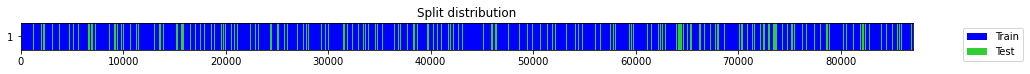

((#69680) [30772,71463,13220,72212,74099,1403,36331,11386,80729,35804...],
 (#17420) [9339,84609,67545,277,35971,52150,73537,15266,65577,14249...])

In [10]:
splits = get_splits(labels, valid_size=.2, stratify=True, random_state=23, shuffle=True)
splits

In [11]:
# archs = [
#     "GRU",
#     "MLP",
#     "FCN",
#     "ResNet",
#     "mWDN",
#     "TCN",
#     "InceptionTime",
#     "XceptionTime",
#     "ResCNN",
#     "TST",
#     "TSiT",
#     "MiniRocket",
#     "XCM",
#     "gMLP",
#     "TSSequencerPlus",
#     "TransformerModel",
#     "LSTMAttention",
#     "GRUAttention",
#     "RNN_FCN",
#     "MLSTM_FCN",
#     "MRNN_FCN",
#     "GRU_FCN",
#     "LSTM_FCN",
#     "TSTPlus"]

In [12]:
archs = [
    'MRNN_FCN', 
    'MLSTM_FCN', 
    'GRU_FCN']

In [13]:
labels_alpha = labels[:,0]
labels_test_alpha = labels_test[:,0]

labels_D = labels[:,1]
labels_test_D = labels_test[:,1]

# Alpha

In [14]:
tfms = [None, TSRegression()]
batch_tfms = TSStandardize(by_sample=True)
dls = get_ts_dls(trajs, labels_alpha, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=128)


  0%|          | 0/3 [00:00<?, ?it/s]

MRNN_FCN


epoch,train_loss,valid_loss,mae,time
0,0.014908,0.004550,0.054827,00:06
1,0.008455,0.004889,0.056893,00:06
2,0.005308,0.005223,0.058591,00:06
3,0.003447,0.004970,0.056931,00:06
4,0.002910,0.003751,0.049919,00:06
5,0.002782,0.002828,0.044474,00:06
6,0.002716,0.002892,0.045051,00:06
7,0.002688,0.004602,0.054854,00:06
8,0.002674,0.002560,0.042605,00:06
9,0.002665,0.002816,0.043920,00:06


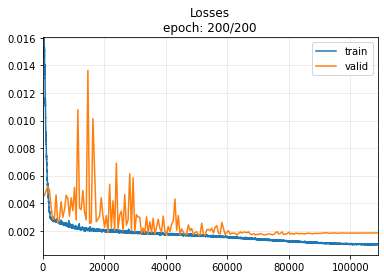

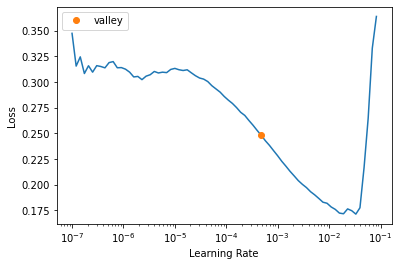

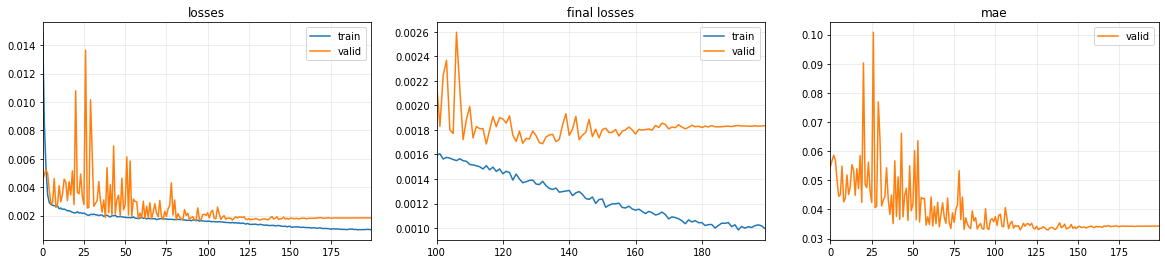

 33%|███▎      | 1/3 [33:54<1:07:49, 2034.61s/it]

MLSTM_FCN


epoch,train_loss,valid_loss,mae,time
0,0.005395,0.003405,0.048958,00:06
1,0.004238,0.003268,0.048200,00:06
2,0.003389,0.002910,0.045748,00:06
3,0.003129,0.003682,0.049738,00:06
4,0.002892,0.004075,0.051819,00:06
5,0.002811,0.002645,0.043341,00:06
6,0.002713,0.002815,0.044157,00:06
7,0.002652,0.003176,0.046179,00:06
8,0.002602,0.002895,0.044173,00:06
9,0.002569,0.003586,0.048841,00:06


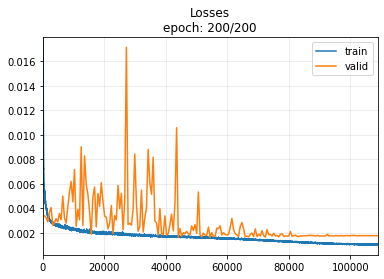

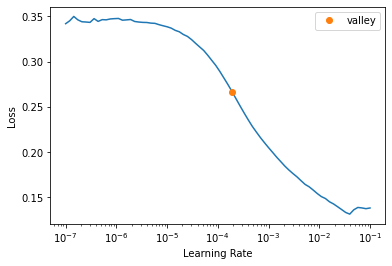

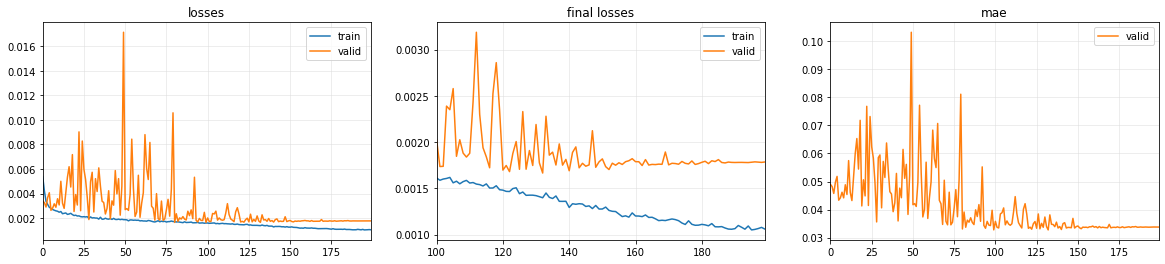

 67%|██████▋   | 2/3 [1:08:05<34:04, 2044.02s/it]

GRU_FCN


epoch,train_loss,valid_loss,mae,time
0,0.007083,0.004266,0.053653,00:05
1,0.004780,0.003530,0.049658,00:05
2,0.003698,0.002918,0.045850,00:05
3,0.003121,0.002764,0.044576,00:05
4,0.002812,0.002700,0.043830,00:05
5,0.002785,0.003729,0.050380,00:05
6,0.002810,0.003060,0.045915,00:05
7,0.002741,0.002993,0.045330,00:05
8,0.002586,0.002911,0.044877,00:05
9,0.002582,0.002975,0.044750,00:05


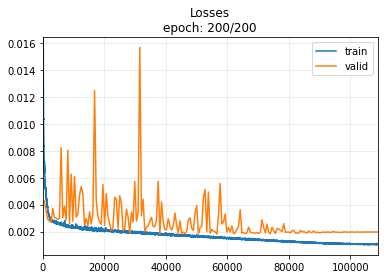

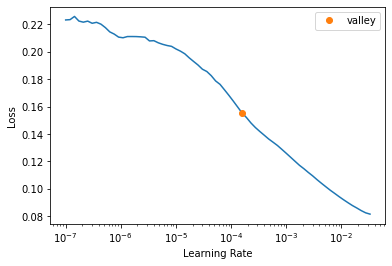

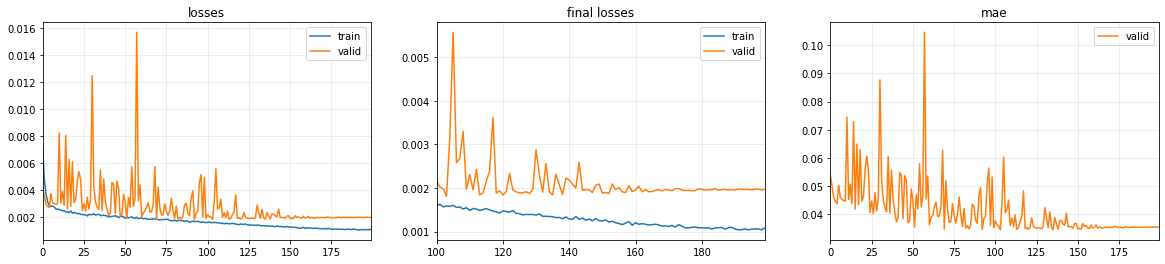

100%|██████████| 3/3 [1:38:58<00:00, 1979.38s/it]


In [15]:
for arch in tqdm(archs):
    
    learn = ts_learner(dls, arch, metrics=mae, cbs=ShowGraph())
    learn.lr_find()
    print(arch)
    learn.fit_one_cycle(200, learn.lr)
    learn.save_all(path='export', dls_fname='dls', model_fname=arch+'_Alpha', learner_fname=arch+'_Alpha')


In [24]:
print(np.mean(preds[mask]))
np.std(preds[mask])

0.5031895467638969


0.03892680268120186

MRNN_FCN: mean = 0.5013408854603767; std = 0.03830195077236991



MLSTM_FCN: mean = 0.5050086799263954; std = 0.03907484416640234



GRU_FCN: mean = 0.5031895467638969; std = 0.03892680268120186



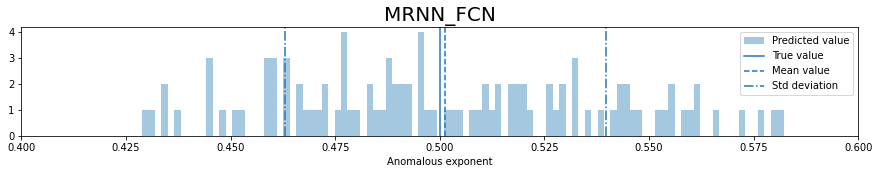

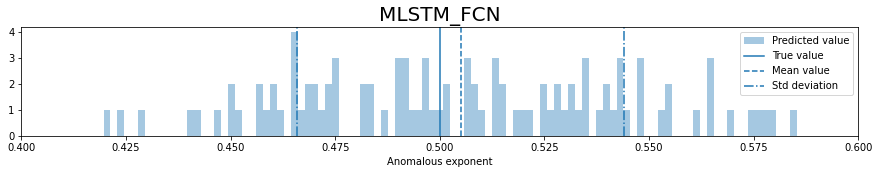

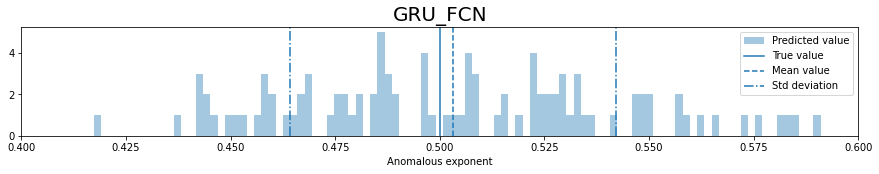

In [35]:
# fig, axes = plt.subplots(len(archs), 1, figsize=(15, 10))

for arch  in archs:
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 2))

    learn = load_learner_all(path='export', dls_fname='dls', model_fname=arch+'_Alpha', learner_fname=arch+'_Alpha')

    probas, _, preds = learn.get_X_preds(trajs_test)
    preds = np.array(preds)[:,0]

    for idx, u in enumerate(np.unique(labels_test_alpha)):

        mask = labels_test_alpha == u
        ax.hist(
            preds[mask],
            facecolor=f"C{idx}",
            bins=100,
            alpha=0.4,
            label="Predicted value" if idx == 0 else "",
        )
        ax.axvline(u, ls="solid", c=f"C{idx}", label="True value" if idx == 0 else "")
        
        ax.axvline(np.mean(preds[mask]), ls="--", c=f"C{idx}", label="Mean value" if idx == 0 else "")
        ax.axvline(np.mean(preds[mask]) - np.std(preds[mask]), ls="-.", c=f"C{idx}")
        ax.axvline(np.mean(preds[mask]) + np.std(preds[mask]), ls="-.", c=f"C{idx}", label="Std deviation" if idx == 0 else "")

        print('{}: mean = {}; std = {}\n'.format(arch, np.mean(preds[mask]), np.std(preds[mask])))


    ax.legend()
    ax.set_xlabel("Anomalous exponent", fontsize=10)
    ax.set_title('{}'.format(arch), fontsize=20)
    ax.xaxis.set_tick_params(labelsize=10)
    ax.yaxis.set_tick_params(labelsize=10)
    ax.set_xlim([np.min(labels_alpha), np.max(labels_alpha)])

# D


In [32]:

tfms = [None, TSRegression()]
batch_tfms = TSStandardize(by_sample=True)
dls = get_ts_dls(trajs, labels_D, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=128)


  0%|          | 0/3 [00:00<?, ?it/s]

MRNN_FCN


epoch,train_loss,valid_loss,mae,time
0,0.020463,0.005419,0.059364,00:06
1,0.012621,0.004666,0.056672,00:06
2,0.007258,0.004176,0.054506,00:06
3,0.004787,0.004255,0.055000,00:06
4,0.003894,0.003864,0.053145,00:06
5,0.003692,0.003702,0.052267,00:06
6,0.003685,0.003990,0.053648,00:06
7,0.003640,0.003629,0.052073,00:06
8,0.003710,0.003789,0.052779,00:06
9,0.003767,0.003954,0.053528,00:06


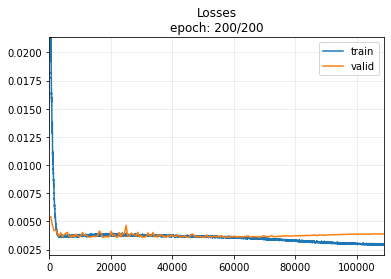

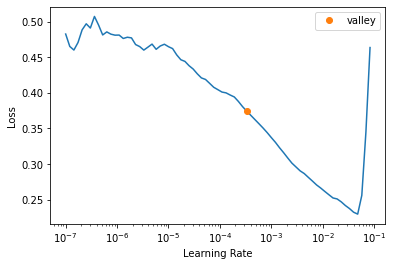

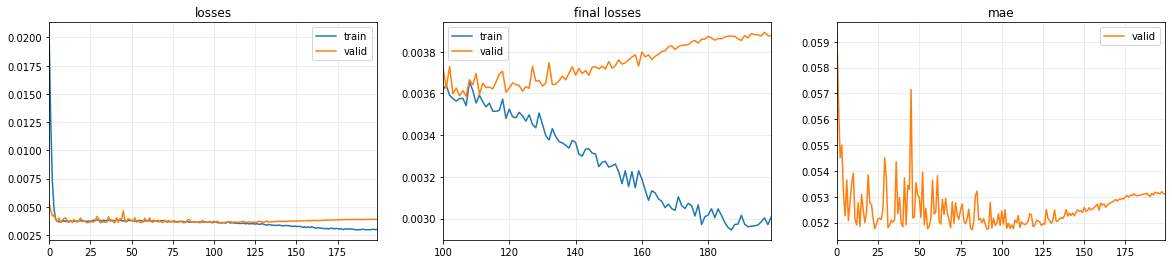

 33%|███▎      | 1/3 [33:58<1:07:56, 2038.15s/it]

MLSTM_FCN


epoch,train_loss,valid_loss,mae,time
0,0.004871,0.004338,0.055307,00:06
1,0.004277,0.003819,0.052975,00:06
2,0.003965,0.003834,0.052941,00:06
3,0.003864,0.003716,0.052399,00:06
4,0.003678,0.003977,0.053590,00:06
5,0.003741,0.004080,0.054273,00:06
6,0.003666,0.003704,0.052357,00:06
7,0.003628,0.003727,0.052506,00:06
8,0.003708,0.003808,0.052780,00:06
9,0.003637,0.004415,0.055805,00:06


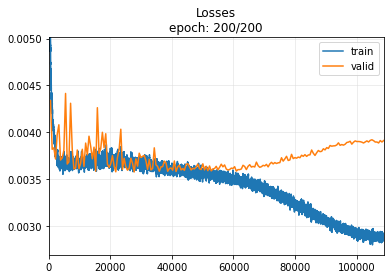

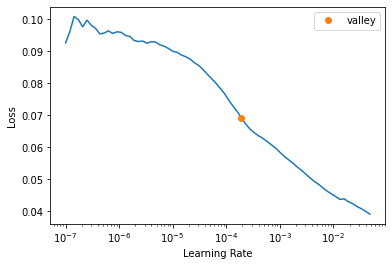

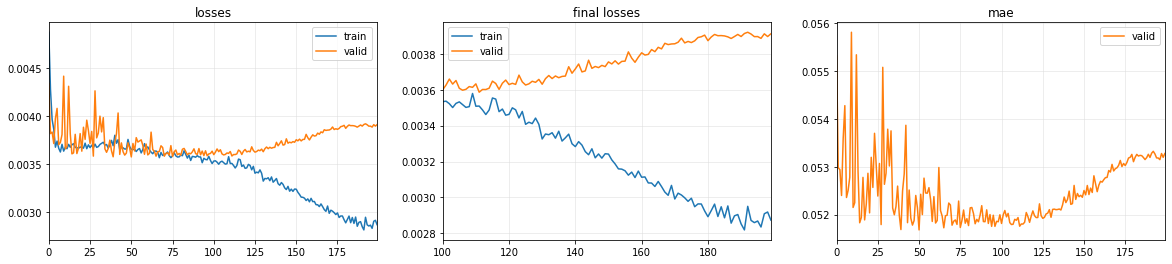

 67%|██████▋   | 2/3 [1:08:13<34:08, 2048.54s/it]

GRU_FCN


epoch,train_loss,valid_loss,mae,time
0,0.009587,0.004242,0.054700,00:05
1,0.006141,0.003997,0.053629,00:05
2,0.004803,0.003729,0.052357,00:05
3,0.004124,0.003814,0.052763,00:05
4,0.003781,0.003693,0.052244,00:05
5,0.003666,0.003669,0.052179,00:05
6,0.003675,0.003831,0.052918,00:05
7,0.003655,0.003594,0.051738,00:05
8,0.003699,0.003788,0.052654,00:05
9,0.003670,0.003710,0.052387,00:05


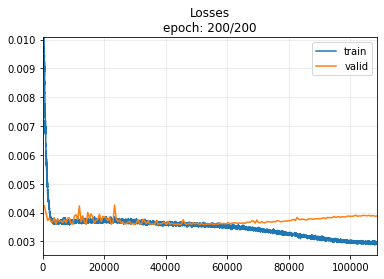

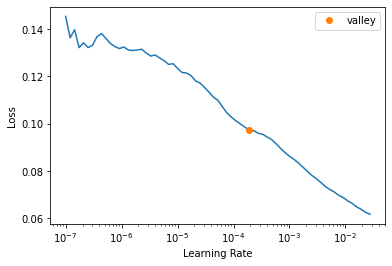

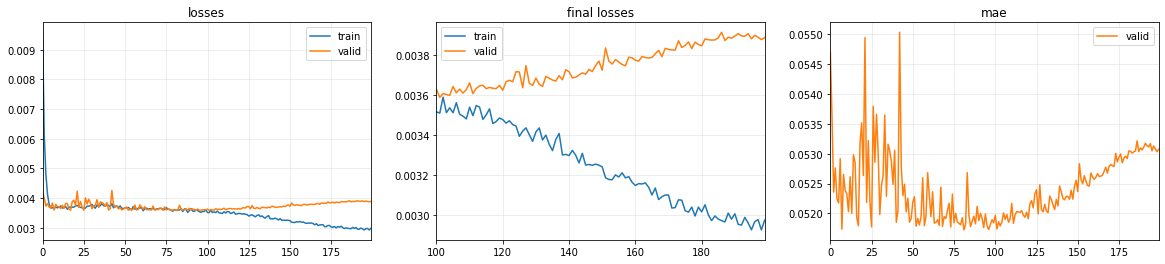

100%|██████████| 3/3 [1:39:12<00:00, 1984.08s/it]


In [33]:

for arch in tqdm(archs):
    
    learn = ts_learner(dls, arch, metrics=mae, cbs=ShowGraph())
    learn.lr_find()
    print(arch)
    learn.fit_one_cycle(200, learn.lr)
    learn.save_all(path='export', dls_fname='dls', model_fname=arch+'_D', learner_fname=arch+'_D')



MRNN_FCN: mean = 0.4994959780573845; std = 0.01677838462984605



MLSTM_FCN: mean = 0.49848678916692735; std = 0.014495791254169646



GRU_FCN: mean = 0.49768266320228577; std = 0.01705522915033851



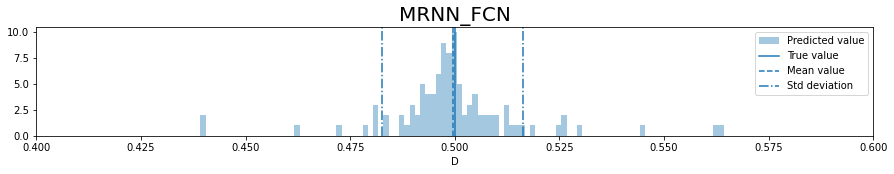

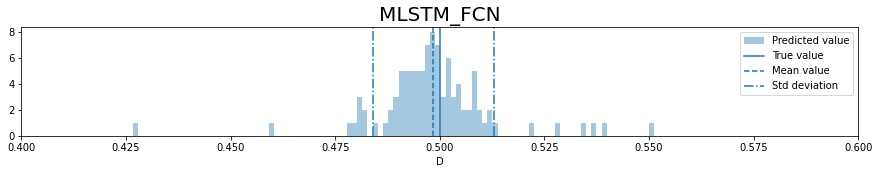

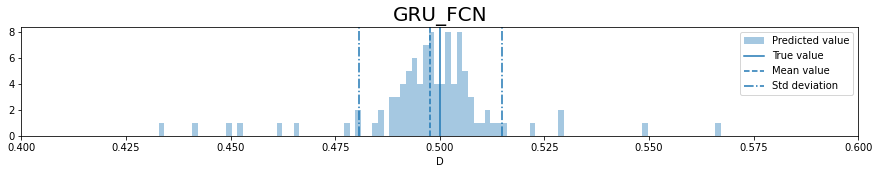

In [36]:

for arch  in archs:
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 2))

    learn = load_learner_all(path='export', dls_fname='dls', model_fname=arch+'_D', learner_fname=arch+'_D')

    probas, _, preds = learn.get_X_preds(trajs_test)
    preds = np.array(preds)[:,0]

    for idx, u in enumerate(np.unique(labels_test_D)):

        mask = labels_test_D == u
        ax.hist(
            preds[mask],
            facecolor=f"C{idx}",
            bins=100,
            alpha=0.4,
            label="Predicted value" if idx == 0 else "",
        )
        ax.axvline(u, ls="solid", c=f"C{idx}", label="True value" if idx == 0 else "")
        
        ax.axvline(np.mean(preds[mask]), ls="--", c=f"C{idx}", label="Mean value" if idx == 0 else "")
        ax.axvline(np.mean(preds[mask]) - np.std(preds[mask]), ls="-.", c=f"C{idx}")
        ax.axvline(np.mean(preds[mask]) + np.std(preds[mask]), ls="-.", c=f"C{idx}", label="Std deviation" if idx == 0 else "")

        print('{}: mean = {}; std = {}\n'.format(arch, np.mean(preds[mask]), np.std(preds[mask])))

    ax.legend()
    ax.set_xlabel("D", fontsize=10)
    ax.set_title('{}'.format(arch), fontsize=20)
    ax.xaxis.set_tick_params(labelsize=10)
    ax.yaxis.set_tick_params(labelsize=10)
    ax.set_xlim([np.min(labels_D), np.max(labels_D)])